# Telco customer churn

## <a id='1'>1. Business understanding</a>

Since the cell phone market is now saturated, the huge growth in the wireless market has tapered off. Therefor as a telcom businnes attracting new customers is much more expensive than retaining existing ones. Therefor a large part of the marketing budget should go into preventing churn. The goal of this notebook is to decide which customers should be offered a special retention deal. 

<b>Interesting fact:</b> the earliest adopters of data mining were telcom businesses to maintain customer retention. <br>(Provost F., Fawcett T)


 <img src="https://images.unsplash.com/photo-1533664488202-6af66d26c44a?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1000&q=80" width="400" height="60" style="float:left"> 

## Overview 

- <a href='#1'>1. Business understanding</a>
- <a href='#2'>2. Data understanding</a>
    - <a href='#2.1'>2.1. Data manipulation</a>
    - <a href='#2.2'>2.2. Exploratory data analysis (EDA)</a>
- <a href='#3'>3. Data preparation</a>
- <a href='#4'>4. Model</a>
- <a href='#5'>5. Evaluation</a>
- <a href='#6'>6. Performance comparison of different models</a>
    - <a href='#6.1'>6.1. Logistic classifier</a>
        - <a href='#6.1.1'>6.1.1 Impact of changing the threshold</a>
    - <a href='#6.2'>6.2. SVM classifier</a>
    - <a href='#6.3'>6.3. Decision tree</a>    
    - <a href='#6.4'>6.4. Naive Bayes (GNB)</a>    
    - <a href='#6.5'>6.5. ROC and AUC</a>    
    - <a href='#6.6'>6.6. Effect of changing the test size on logistic regression model performance</a>    
    - <a href='#6.7'>6.7. Feature selection impact on model performance (logistic regression)</a>    
- <a href='#7'>7. Create function to predict churn probability via API</a>
- <a href='#8'>8. Ranking top 20 customers most likely to churn </a>

In [1]:
#import modules

import numpy as np #scientific computing library
import pandas as pd  #data analysis and manipulation library

import matplotlib.pyplot as plt #library for creating static, animated, and interactive visualizations 
import seaborn as sns #data visualization library based on matplotlib
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
# sns.set(style="white", context="talk") #set to a specific seaborn plot style

import plotly.offline as py # to create interactive, publication-quality graphs
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

## <a id='2'>2. Data understanding</a>

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The dataset includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support,and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

In [2]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No


In [3]:
print("ATTRIBUTES OVERVIEW"+"\n"+"-"*20+"\n")
print(df.info())
print("\n"+"HOW MANY UNIQUE VALUES PER ATTRIBUTE?"+"\n"+"-"*40+"\n")
print(df.nunique())

ATTRIBUTES OVERVIEW
--------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  

* Senior citizen: in the US they consider someone from 60 years old onwards to be a senior citizen.
* Dependents: having to provide support for family members.
* Tenure: the period of time a person holds a position.
* Multiple lines: a multi-line phone system condenses multiple lines into a single device which means that more than one person will be able to make or receive calls at the same time.

### <a id='2.1'>2.1 Data manipulation</a>

In [4]:
#Check all attributes for cells with whitespaces
def check_all_columns_for_whitespaces(the_df):
    for c in the_df.columns:
        for i in the_df[str(c)]:
            if str(i) == " ":
                print(str(c)+' has a cell with a whitespace')
            else:
                pass

check_all_columns_for_whitespaces(df)

TotalCharges has a cell with a whitespace
TotalCharges has a cell with a whitespace
TotalCharges has a cell with a whitespace
TotalCharges has a cell with a whitespace
TotalCharges has a cell with a whitespace
TotalCharges has a cell with a whitespace
TotalCharges has a cell with a whitespace
TotalCharges has a cell with a whitespace
TotalCharges has a cell with a whitespace
TotalCharges has a cell with a whitespace
TotalCharges has a cell with a whitespace


In [5]:
#Replace whitespaces in TotalCharges with NAN (not a number: numeric data type to represent any value that is undefined)
df["TotalCharges"] = df["TotalCharges"].replace(" ",np.nan)

#Remove NAN instances from the dataframe
df = df[df["TotalCharges"].notnull()]
#Reset the index
df = df.reset_index()[df.columns]

#TotalCharges is of dtype object, while it contains continuous numerical values, therefor change to float type
df['TotalCharges'] = df['TotalCharges'].astype(float)

#ID is useless, also no relationship between numeric part of ID and target value.
df = df.drop('customerID',axis=1)

#Replace 
yn_map = { 0:'No',1:'Yes' }
df['SeniorCitizen'] = df['SeniorCitizen'].map(yn_map)

In [6]:
print(df['InternetService'].unique())
print("Before: "+str(df['MultipleLines'].unique())) #No phone service = No

#Replace "No phone service" with "No"
df['MultipleLines'] = df['MultipleLines'].replace('No phone service','No')
print("After: "+str(df['MultipleLines'].unique()))

['DSL' 'Fiber optic' 'No']
Before: ['No phone service' 'No' 'Yes']
After: ['No' 'Yes']


In [7]:
#All the following attributed have a 3th label "No internet service"
#Replace it with equivalent "No"

print("Before:"+"\n")
for c in df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]:
    print(df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']][str(c)].unique())
    
to_replace_columns = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

for i in to_replace_columns:
    df[i] = df[i].replace('No internet service','No')

print("\n"+"After:"+"\n")
for c in df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]:
    print(df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']][str(c)].unique())

Before:

['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']

After:

['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


In [8]:
print(df['Contract'].unique())
print(df['PaymentMethod'].unique())

['Month-to-month' 'One year' 'Two year']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [9]:
#df for churn and non churn customers
churn     = df[df["Churn"] == "Yes"]
not_churn = df[df["Churn"] == "No"]

#Separating catagorical and numerical columns
target_col = ["Churn"]
cat_cols   = df.nunique()[df.nunique() < 17].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col] # remove target column
num_cols   = [x for x in df.columns if x not in cat_cols + target_col]

### <a id='2.2'>2.2 Exploratory data analysis (EDA)</a>

### Numerical variables

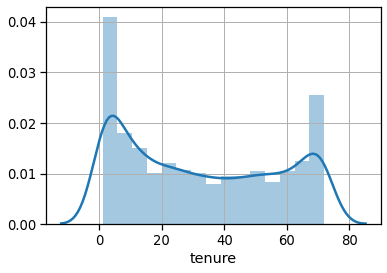

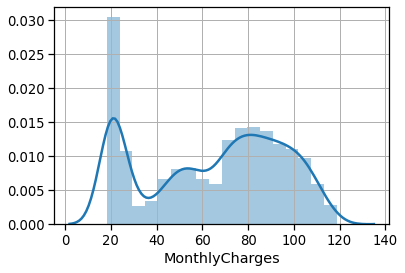

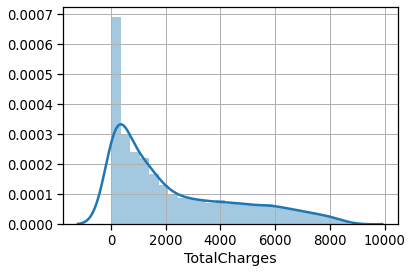

In [10]:
 for c in num_cols:
    sns.distplot(df[c])
    plt.grid()
    plt.show()

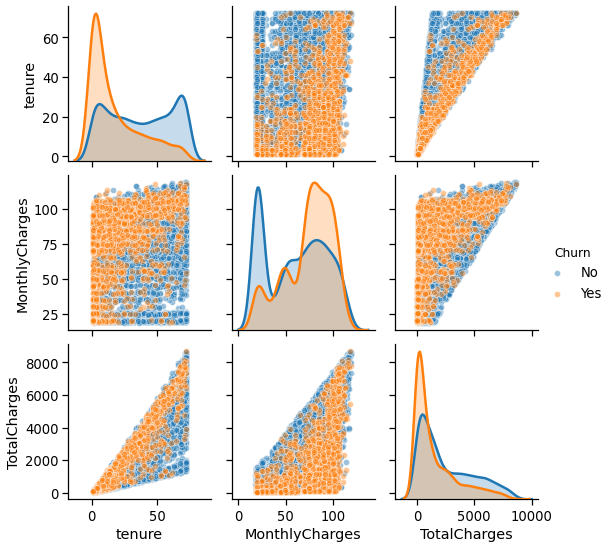

In [11]:
sns.pairplot(df[['tenure','MonthlyCharges','TotalCharges','Churn']], hue = 'Churn',plot_kws = {'alpha': 0.45})
plt.show()

* Customers with low tenure are more likely to churn.
* Customers with high monthly charges are more likely to churn.


In [12]:
#After EDA the continuous numerical values can be binned
#Data binning: a way to group numbers of more or less continuous values into a smaller number of "bins"

#discrete numerical values

#Bin tenure even further
df['tenure_bin_round'] = np.array(np.floor(np.array(df['tenure']) / 4.))
print("Reducing from {} bins to {} bins".format(str(df['tenure'].nunique()),str(df['tenure_bin_round'].nunique())))

#continuous numerical values

#Bin the monthly charges.
df['MonthlyCharges_bin_round'] = np.array(np.floor(np.array(df['MonthlyCharges']) / 10.))
print("Reducing from {} unique values to {} bins".format(str(df['MonthlyCharges'].nunique()),str(df['MonthlyCharges_bin_round'].nunique())))

#Bin the total charges.
df['TotalCharges_bin_round'] = np.array(np.floor(np.array(df['TotalCharges']) / 1000.))
print("Reducing from {} unique values to {} bins".format(str(df['TotalCharges'].nunique()),str(df['TotalCharges_bin_round'].nunique())))


Reducing from 72 bins to 19 bins
Reducing from 1584 unique values to 11 bins
Reducing from 6530 unique values to 9 bins


In [13]:
#drop original variables after binning
df = df.drop(['tenure','MonthlyCharges','TotalCharges'],axis=1)

### Categorical variables

In [14]:
print("People churning {0:,.2f}%".format(100*(len(churn)/len(df))))
print("People not churning {0:,.2f}%".format(100*(len(not_churn)/len(df))))

People churning 26.58%
People not churning 73.42%


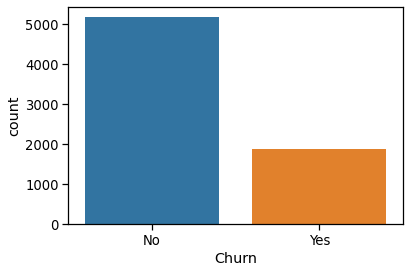

In [15]:
sns.countplot(df['Churn'])
plt.show()

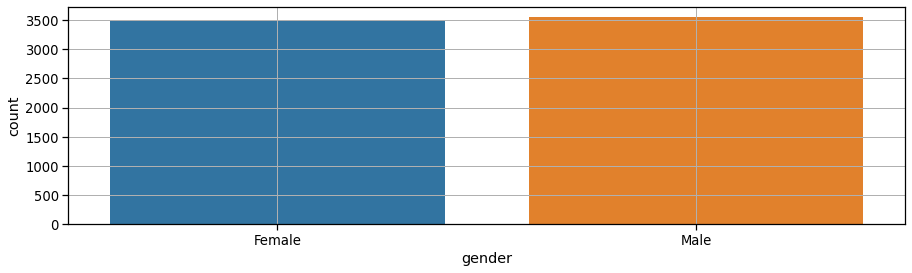

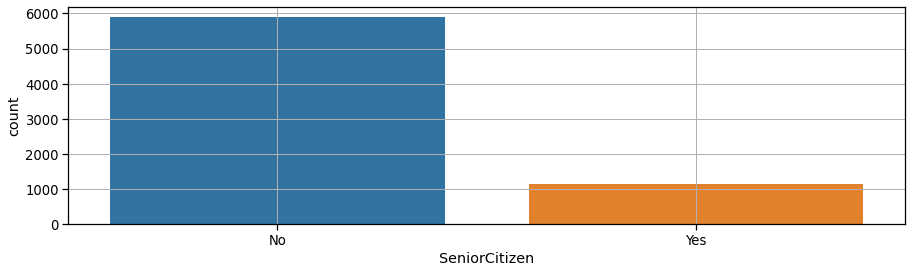

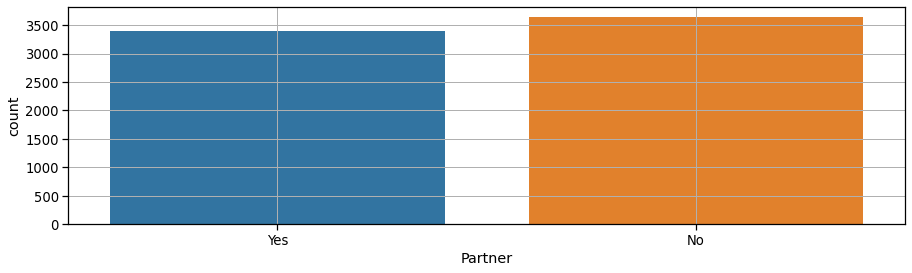

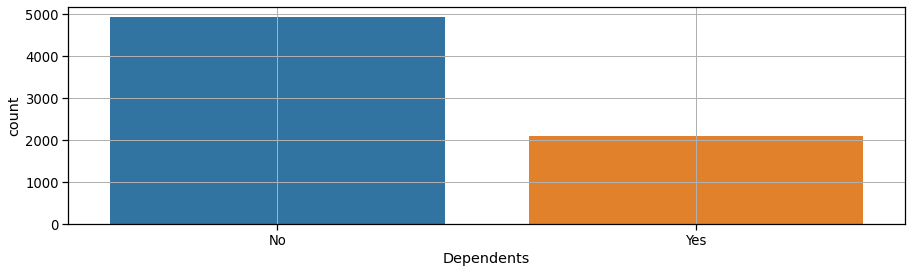

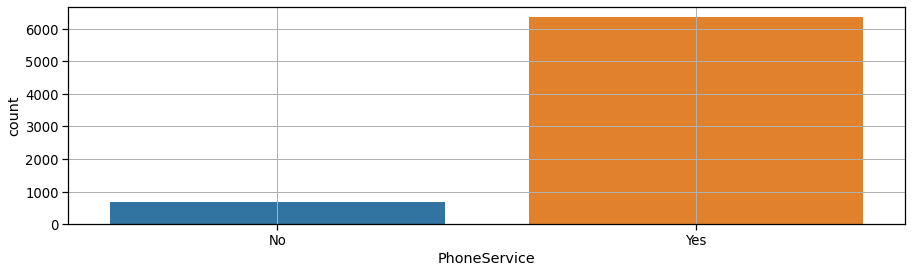

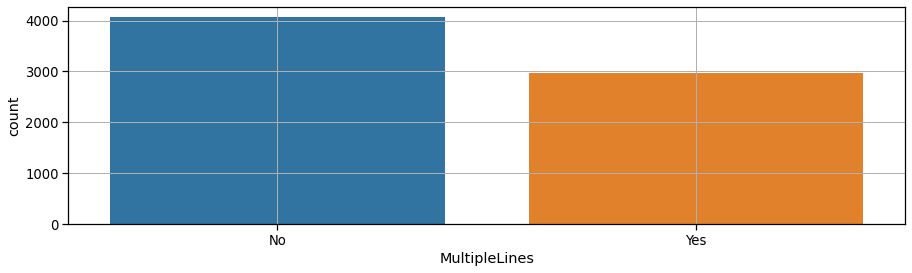

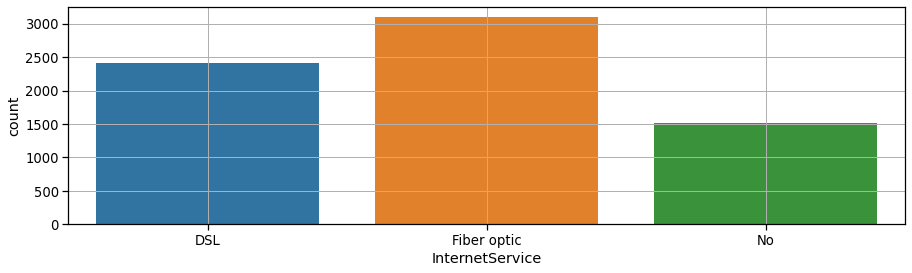

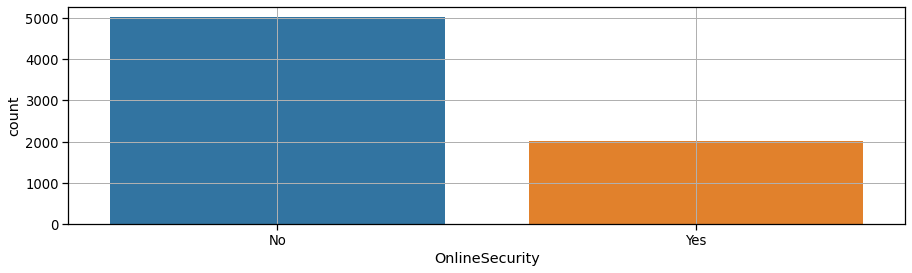

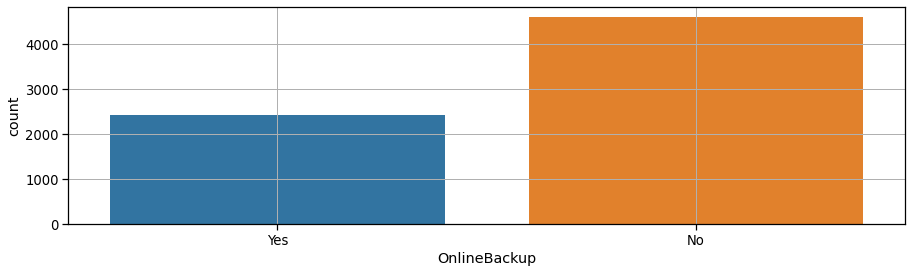

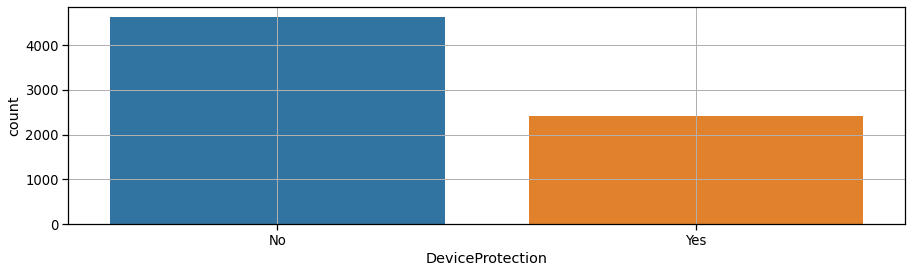

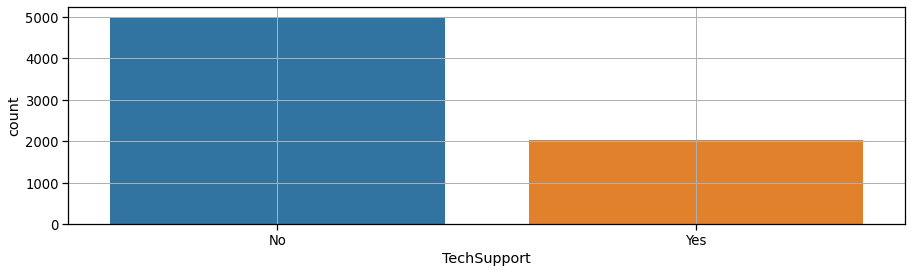

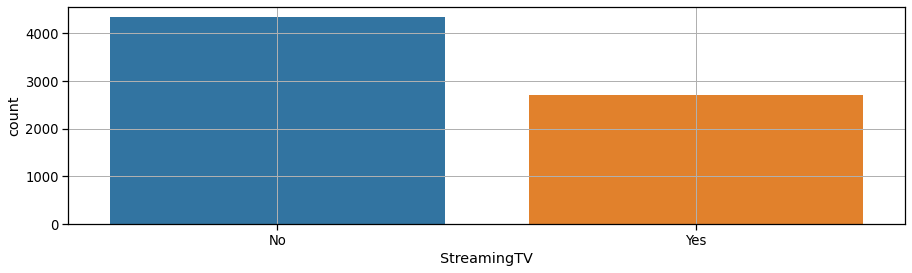

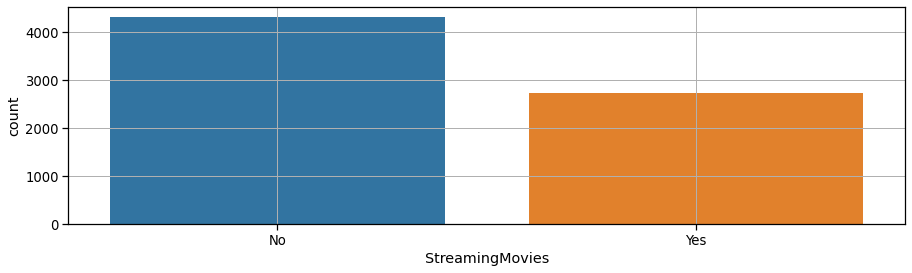

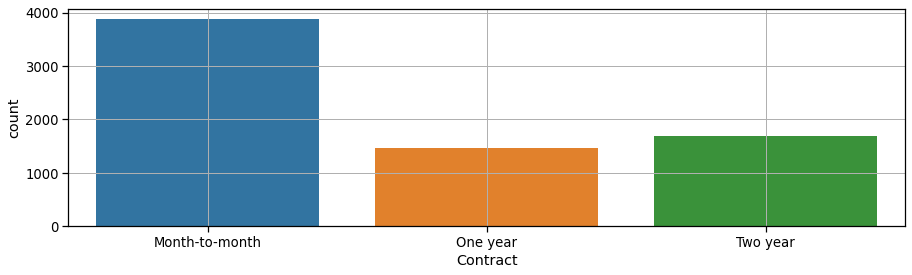

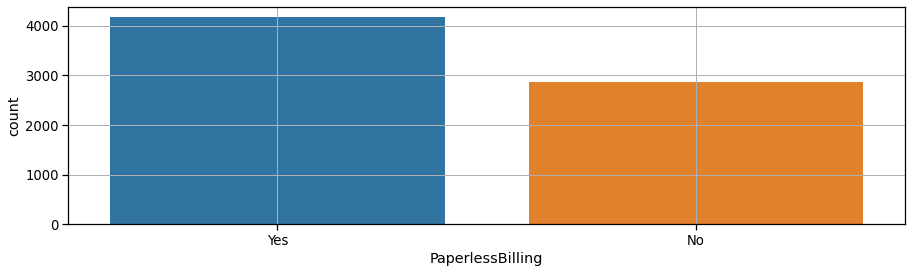

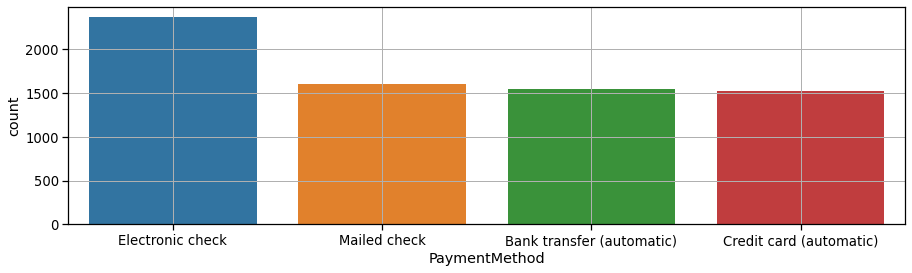

In [16]:
for c in cat_cols:
    plt.figure(figsize=(15,4))
    sns.countplot(df[c])
    plt.grid()
    plt.show()

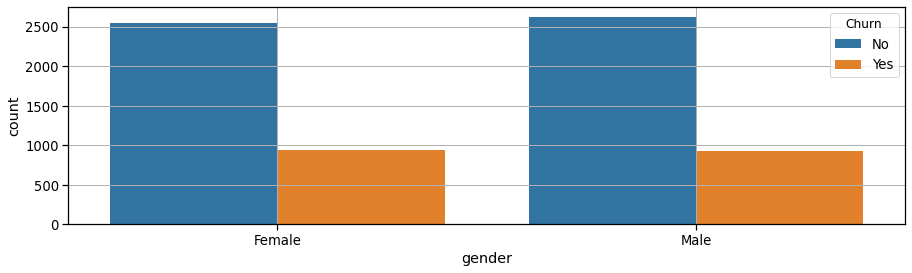

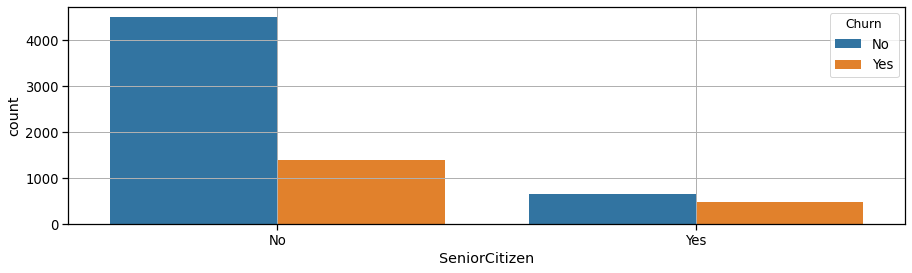

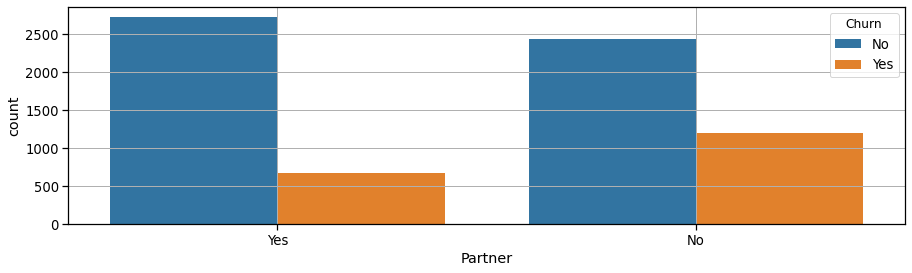

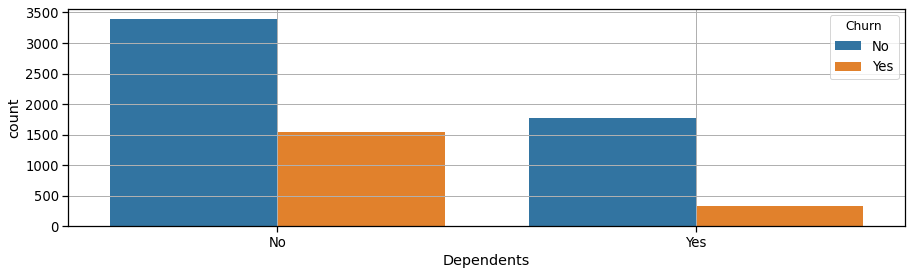

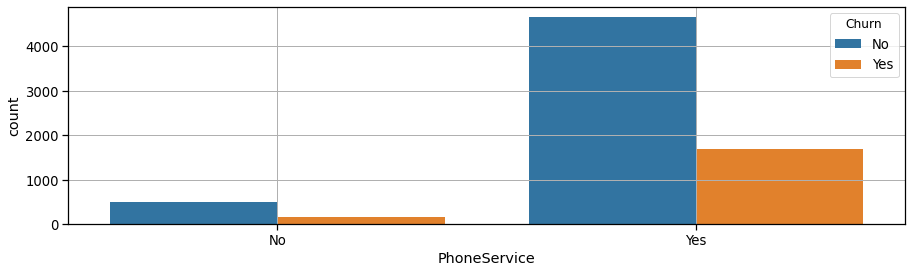

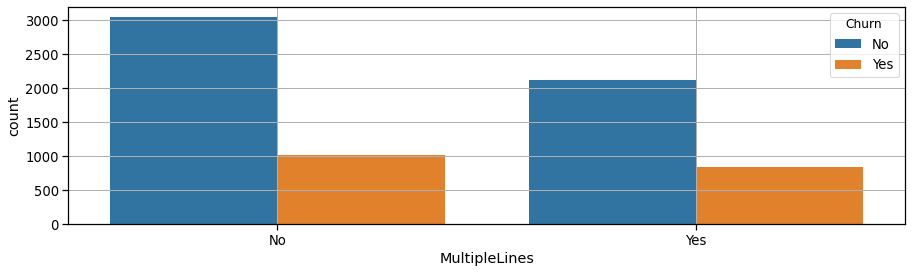

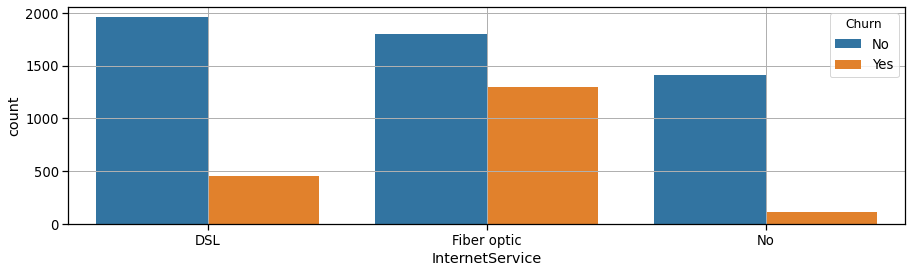

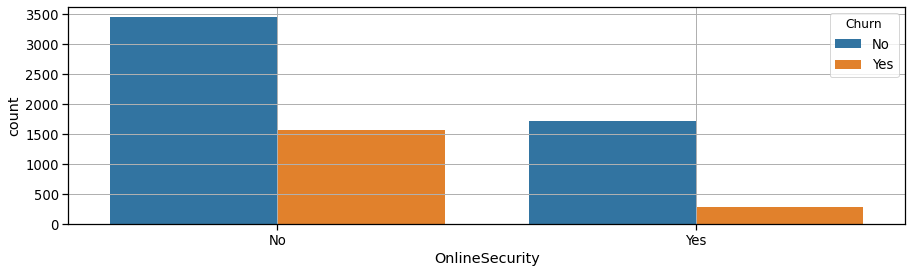

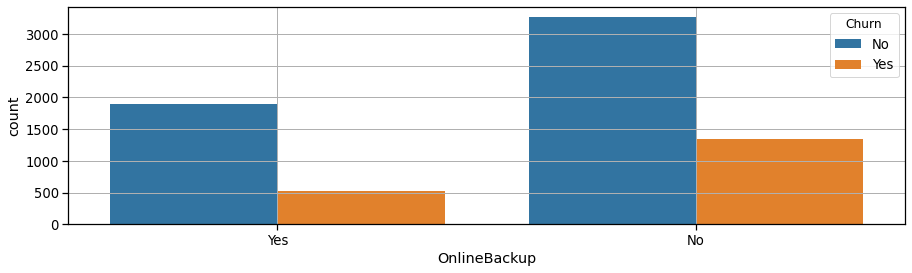

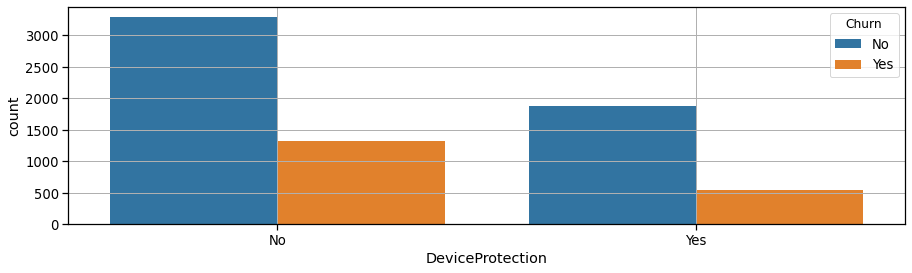

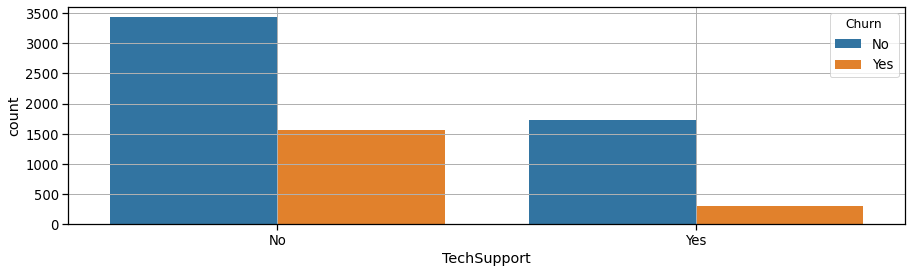

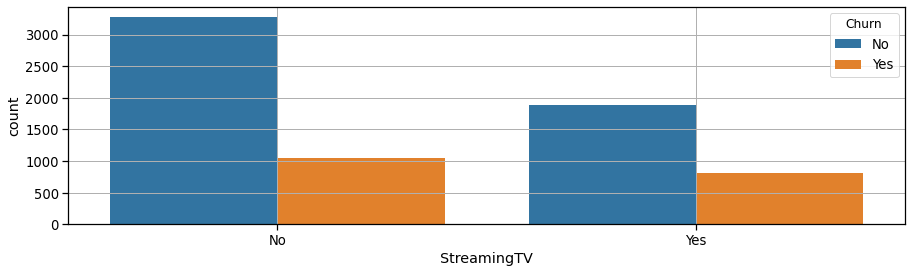

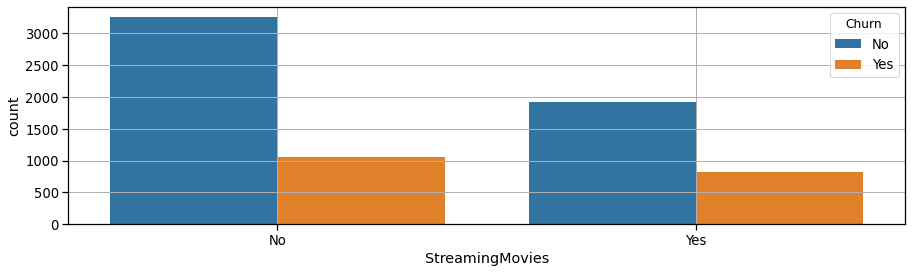

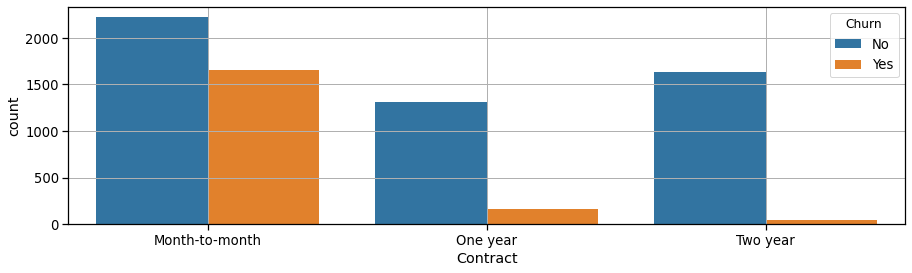

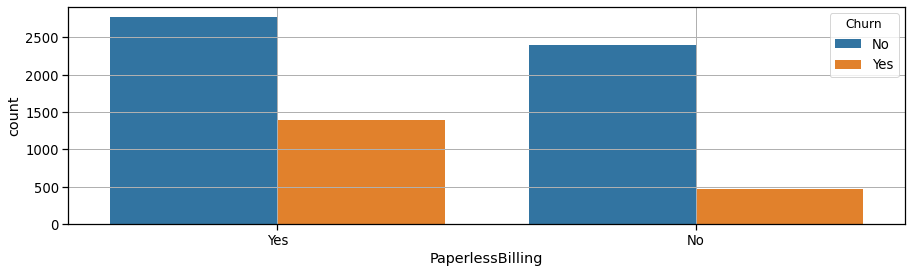

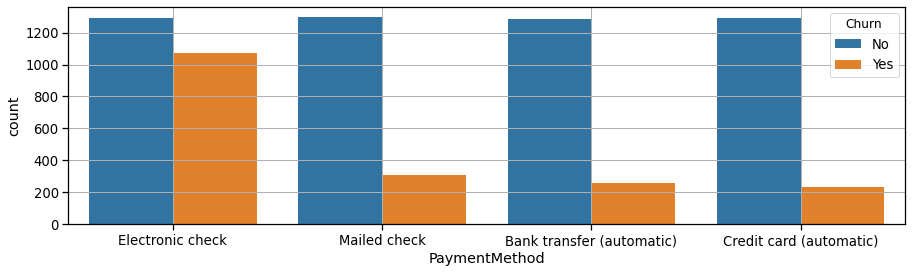

In [17]:
for c in cat_cols:
    plt.figure(figsize=(15,4))
    sns.countplot(x=c, hue="Churn", data=df)
    plt.grid()
    plt.show()

In [18]:
#Change dtype of binned variables to int
print(type(df['TotalCharges_bin_round'].iloc[2]))

convert_to_int = ['tenure_bin_round','MonthlyCharges_bin_round','TotalCharges_bin_round']

for c in convert_to_int:
    df[c] = df[c].astype(int)
    
print(type(df['TotalCharges_bin_round'].iloc[2]))

<class 'numpy.float64'>
<class 'numpy.int64'>


## <a id='3'>3. Data preparation</a>

In [19]:
print(df.shape)
df.head(4)

(7032, 20)


,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure_bin_round,MonthlyCharges_bin_round,TotalCharges_bin_round
0,Female,No,Yes,No,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No,0,2,0
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No,8,5,1
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,0,5,0
3,Male,No,No,No,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No,11,4,1


In [20]:
#Attributes
X = df.drop('Churn',axis=1)
print(X.shape)

#Target
y = df['Churn']#)np.array(.reshape(-1,1)
print(y.shape)

(7032, 19)
(7032,)


In [21]:
print(X.shape)
print(y.shape)

(7032, 19)
(7032,)


In [22]:
X.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_bin_round',
       'MonthlyCharges_bin_round', 'TotalCharges_bin_round'],
      dtype='object')

In [23]:
#Encode categorical variables
from sklearn.preprocessing import OrdinalEncoder
ohe = OrdinalEncoder()
X = pd.DataFrame(ohe.fit_transform(X),columns=['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_bin_round',
       'MonthlyCharges_bin_round', 'TotalCharges_bin_round'])   
X = X.astype(int) # convert from float to int
print(X.shape)
print(type(X))

#Encode target labels with value between 0 and n_classes-1.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = pd.DataFrame(le.fit_transform(y))
print(y.shape)
print(type(y))

(7032, 19)
<class 'pandas.core.frame.DataFrame'>
(7032, 1)
<class 'pandas.core.frame.DataFrame'>


In [24]:
X.nunique()>2

gender                      False
SeniorCitizen               False
Partner                     False
Dependents                  False
PhoneService                False
MultipleLines               False
InternetService              True
OnlineSecurity              False
OnlineBackup                False
DeviceProtection            False
TechSupport                 False
StreamingTV                 False
StreamingMovies             False
Contract                     True
PaperlessBilling            False
PaymentMethod                True
tenure_bin_round             True
MonthlyCharges_bin_round     True
TotalCharges_bin_round       True
dtype: bool

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer((OneHotEncoder(),['InternetService','Contract','PaymentMethod',
                                                         'tenure_bin_round','MonthlyCharges_bin_round',
                                                         'TotalCharges_bin_round']),remainder='passthrough')
print(column_trans.fit_transform(X).shape)
column_trans.fit_transform(X)

(7032, 62)


array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 1., 1.]])

## <a id='4'>4. Model</a>

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [27]:
logreg=LogisticRegression(solver='lbfgs',max_iter=7600)
pipe = make_pipeline(column_trans,logreg)

## <a id='5'>5. Evaluation</a>

Use cross-validation (CV) for evaluation of the model.

CV is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. 

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

<div class="img-with-text">
  <img src="https://www.justintodata.com/wp-content/uploads/2020/06/image-8.png" alt="image" style="width:45%"  align="left">

In [28]:
y = y[0]

In [29]:
from sklearn.model_selection import cross_val_score
print("Accuracy: {0:,.3f}%".format(cross_val_score(pipe,X, y,cv=10,scoring='accuracy').mean()))
print("recall: {0:,.3f}%".format(cross_val_score(pipe,X, y,cv=10,scoring='recall').mean()))
print("precision: {0:,.3f}%".format(cross_val_score(pipe,X, y,cv=10,scoring='precision').mean()))
print("f1: {0:,.3f}%".format((cross_val_score(pipe,X, y,cv=10,scoring='f1').mean())))

Accuracy: 0.805%
recall: 0.534%
precision: 0.669%
f1: 0.593%


## <a id='6'>6. Performance comparison of different models</a>

- Modeling performance from now one will be without pipeline and without "make_column_transformer" of features with >2 labels
- So the following features have more than 2 labels:
        -['InternetService',
        'Contract',
        'PaymentMethod',
        'tenure_bin_round',
        'MonthlyCharges_bin_round',
        'TotalCharges_bin_round']

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

### <a id='6.1'>6.1. Logistic classifier</a>

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1824
           1       0.64      0.53      0.58       638

    accuracy                           0.80      2462
   macro avg       0.74      0.71      0.72      2462
weighted avg       0.79      0.80      0.79      2462



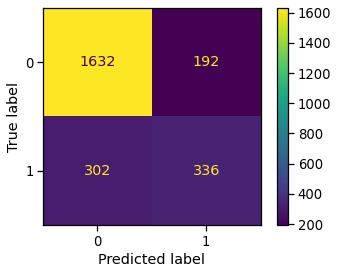

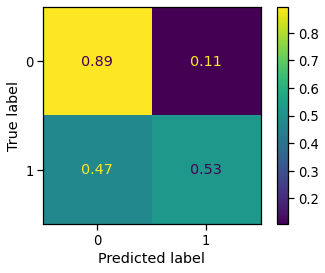

In [31]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
log_predictions = logmodel.predict(X_test)
print(classification_report(y_test,log_predictions))
plot_confusion_matrix(logmodel, X_test, y_test)
plt.show()
plot_confusion_matrix(logmodel, X_test, y_test, normalize='true')
plt.show()

### <a id='6.1.1'>6.1.1. Impact of changing the threshold</a>

- Threshold of 0.5 (probability) used by default for binary classification
- Changing the threshold changes the sensitivity and specificity (they have an inverse relationship) of the model.
- First put time and effort in making a good model, changing the threshold is something you can do at the end.
- Depending on usecase increase or decrease threshold.

In [32]:
# first 10 prediction responses
print(logmodel.predict(X_test)[0:10]) 
print('\n')
# first 10 predicted probabilities of class membership
print(logmodel.predict_proba(X_test)[0:10]) 
print('\n')
# first 10 predicted probabilities of class 1
print(logmodel.predict_proba(X_test)[0:10,1])

#place results in variable
y_logistic_pred_prob = np.array(logmodel.predict_proba(X_test)[:,1]).reshape(-1,1)

[0 0 1 0 0 1 0 1 0 0]


[[0.99645129 0.00354871]
 [0.8725528  0.1274472 ]
 [0.21711427 0.78288573]
 [0.83416017 0.16583983]
 [0.66744225 0.33255775]
 [0.49477646 0.50522354]
 [0.86230875 0.13769125]
 [0.23872393 0.76127607]
 [0.79950621 0.20049379]
 [0.98462764 0.01537236]]


[0.00354871 0.1274472  0.78288573 0.16583983 0.33255775 0.50522354
 0.13769125 0.76127607 0.20049379 0.01537236]


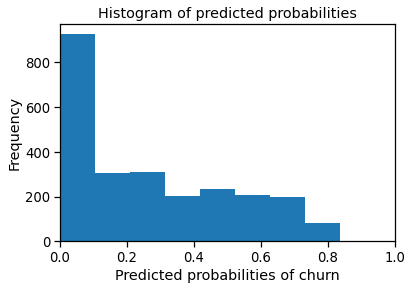

In [33]:
plt.rcParams['font.size'] = 14
plt.hist(logmodel.predict_proba(X_test)[:,1], bins=8)
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probabilities of churn')
plt.ylabel('Frequency')
plt.show()

If we would lower the threshold from 0.5 to 0.4, more people would be predicted to churn. (sensitivity of the classifier)

In [34]:
from sklearn.preprocessing import binarize
y_logistic_pred_class = binarize(y_logistic_pred_prob,threshold=0.4)[:]

In [35]:
y_logistic_pred_prob[0:10][:,0]

array([0.00354871, 0.1274472 , 0.78288573, 0.16583983, 0.33255775,
       0.50522354, 0.13769125, 0.76127607, 0.20049379, 0.01537236])

In [36]:
y_logistic_pred_class[0:10][:,0]

array([0., 0., 1., 0., 0., 1., 0., 1., 0., 0.])

In [37]:
confusion_matrix(y_test,log_predictions)

array([[1632,  192],
       [ 302,  336]])

In [38]:
confusion_matrix(y_test,y_logistic_pred_class)

array([[1504,  320],
       [ 203,  435]])

In [39]:
print("Increase in sensitivity (recall) from {:0.2f} to {:0.2f}".format((320/(320+290)),416/(416+194)))

Increase in sensitivity (recall) from 0.52 to 0.68


In [40]:
print("Decrease in specificity from {:0.2f} to {:0.2f}".format((1529/(1529+182)),1412/(1412+299)))

Decrease in specificity from 0.89 to 0.83


### <a id='6.2'>6.2. SVM classifier</a>

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1824
           1       0.66      0.39      0.49       638

    accuracy                           0.79      2462
   macro avg       0.74      0.66      0.68      2462
weighted avg       0.77      0.79      0.77      2462



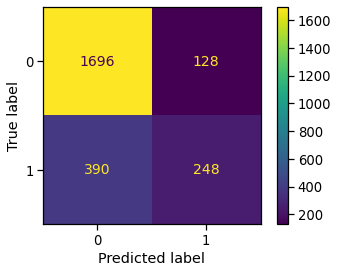

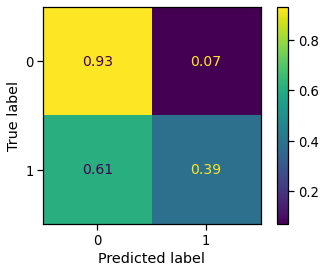

In [41]:
from sklearn.svm import SVC
svc_model = SVC(kernel='rbf',random_state=4,probability=True)
svc_model.fit(X_train, y_train)
SVM_predictions = svc_model.predict(X_test)
print(classification_report(y_test,SVM_predictions))
plot_confusion_matrix(svc_model, X_test, y_test)
plt.show()
plot_confusion_matrix(svc_model, X_test, y_test, normalize='true')
plt.show()

### <a id='6.3'>6.3. Decision tree</a>

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [42]:
from sklearn import tree

In [43]:
tree_clf = tree.DecisionTreeClassifier(criterion='entropy')
tree_clf = tree_clf.fit(X_train, y_train)
tree_predictions = tree_clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1824
           1       0.47      0.49      0.48       638

    accuracy                           0.73      2462
   macro avg       0.65      0.65      0.65      2462
weighted avg       0.73      0.73      0.73      2462



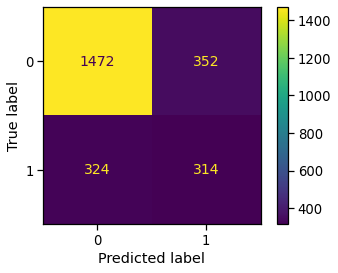

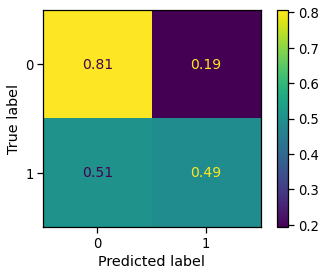

In [44]:
print(classification_report(y_test,tree_predictions))
plot_confusion_matrix(tree_clf, X_test, y_test)
plt.show()
plot_confusion_matrix(tree_clf, X_test, y_test, normalize='true')
plt.show()

In [45]:
import graphviz 
dot_data = tree.export_graphviz(tree_clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("beautiful_tree")

'beautiful_tree.pdf'

### <a id='6.4'>6.4. Naive Bayes</a>

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

In [46]:
#GaussianNB implements the Gaussian Naive Bayes algorithm for classification. 

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb_predictions = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total {} points : {}".format(X_test.shape[0], (y_test != gnb_predictions).sum()))

Number of mislabeled points out of a total 2462 points : 598


              precision    recall  f1-score   support

           0       0.89      0.77      0.82      1824
           1       0.52      0.73      0.61       638

    accuracy                           0.76      2462
   macro avg       0.71      0.75      0.72      2462
weighted avg       0.79      0.76      0.77      2462







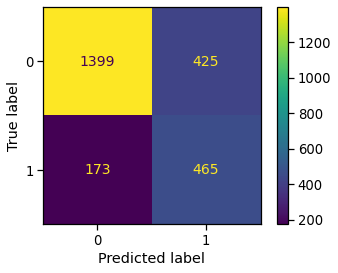

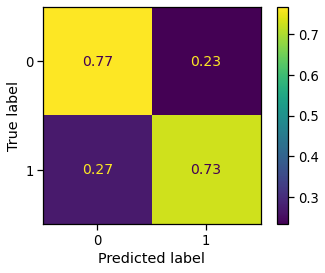

In [47]:
print(classification_report(y_test,gnb_predictions))
print('\n')
plot_confusion_matrix(gnb, X_test, y_test)
print('\n')
plot_confusion_matrix(gnb, X_test, y_test, normalize='true')

### <a id='6.5'>6.5. ROC and AUC</a>

“A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.”

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

In [48]:
# store the predicted probabilities for class 1
y_logistic_pred_prob = np.array(logmodel.predict_proba(X_test)[:,1]).reshape(-1,1)
y_svm_pred_prob = np.array(svc_model.predict_proba(X_test)[:,1]).reshape(-1,1)
y_tree_prob = np.array(tree_clf.predict_proba(X_test)[:,1]).reshape(-1,1)
y_gnb_prob = np.array(gnb.predict_proba(X_test)[:,1]).reshape(-1,1)

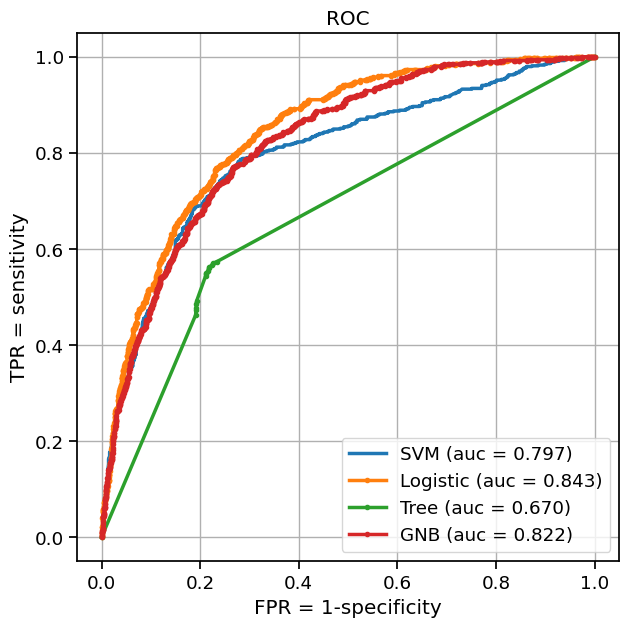

In [49]:
from sklearn.metrics import roc_curve, auc

#logistic tpr and fpr
logistic_fpr, logistic_tpr, threshold_log = roc_curve(y_test, y_logistic_pred_prob)
auc_logistic = auc(logistic_fpr, logistic_tpr)

#SVM tpr and fpr
svm_fpr, svm_tpr, threshold_svm = roc_curve(y_test, y_svm_pred_prob)
auc_svm = auc(svm_fpr, svm_tpr)

#Tree tpr and fpr
tree_fpr, tree_tpr, threshold_tree = roc_curve(y_test, y_tree_prob,drop_intermediate=False)
auc_tree = auc(tree_fpr, tree_tpr)

#GNB tpr and fpr
gnb_fpr, gnb_tpr, threshold_gnb = roc_curve(y_test, y_gnb_prob)
auc_gnb = auc(gnb_fpr, gnb_tpr)


#plot
plt.figure(figsize=(7,7), dpi=100)
plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (auc = %0.3f)' % auc_svm)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)
plt.plot(tree_fpr, tree_tpr, marker='.', label='Tree (auc = %0.3f)' % auc_tree)
plt.plot(gnb_fpr, gnb_tpr, marker='.', label='GNB (auc = %0.3f)' % auc_gnb)

plt.xlabel('FPR = 1-specificity')
plt.ylabel('TPR = sensitivity')
plt.title('ROC')
plt.grid(True)
plt.legend()
plt.show()

In [50]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score

#Logistic regression
print(cross_val_score(logmodel, X, y, cv=10, scoring='roc_auc').mean())
#SVM
print(cross_val_score(svc_model, X, y, cv=10, scoring='roc_auc').mean())
#Decision tree
print(cross_val_score(tree_clf, X, y, cv=10, scoring='roc_auc').mean())
#GNB
print(cross_val_score(gnb, X, y, cv=10, scoring='roc_auc').mean())

0.8442692882128361
0.8028968949924776
0.6664225344030336
0.8218148635282508


In [51]:
# calculate AUC with metrics.roc_auc_score
from sklearn import metrics
print(metrics.roc_auc_score(y_test, y_logistic_pred_prob))
print(metrics.roc_auc_score(y_test, y_svm_pred_prob))
print(metrics.roc_auc_score(y_test, y_tree_prob))
print(metrics.roc_auc_score(y_test, y_gnb_prob))

0.8431471876203047
0.7971963853599517
0.6701559320519166
0.822184956415333


### <a id='6.6'>6.6. Effect of changing the test size on model performance (logistic regression)</a>

In [52]:
roc_list = []
acc = []
prec = []
rec = []

for spc in np.linspace(0.1,0.9,num=50):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=spc, random_state=42)
    logmodel = LogisticRegression()
    logmodel.fit(X_train,y_train)
    log_predictions = logmodel.predict(X_test)
    roc_list.append(cross_val_score(logmodel, X_test, y_test, cv=10, scoring='roc_auc').mean())   
    acc.append((confusion_matrix(y_test, log_predictions)[0][0]+
               confusion_matrix(y_test, log_predictions)[1][1])/(
               confusion_matrix(y_test, log_predictions)[0][0]+
              confusion_matrix(y_test, log_predictions)[0][1]+
              confusion_matrix(y_test, log_predictions)[1][0]+
              confusion_matrix(y_test, log_predictions)[1][1]))
    prec.append((confusion_matrix(y_test, log_predictions)[1][1])/(               
              confusion_matrix(y_test, log_predictions)[0][1]+              
              confusion_matrix(y_test, log_predictions)[1][1]))
    rec.append((confusion_matrix(y_test, log_predictions)[1][1])/(               
              confusion_matrix(y_test, log_predictions)[1][1]+              
              confusion_matrix(y_test, log_predictions)[1][0]))

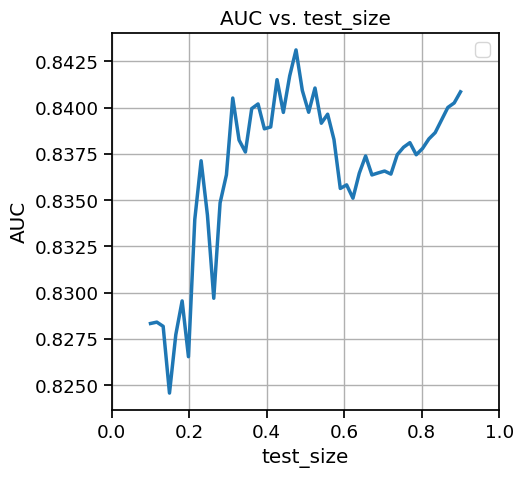

In [53]:
plt.figure(figsize=(5,5), dpi=100)
plt.plot(np.linspace(0.1,0.9,num=50), roc_list)
plt.xlim(0,1)
plt.xlabel('test_size')
plt.ylabel('AUC')
plt.title('AUC vs. test_size')
plt.grid(True)
plt.legend()
plt.show()

In [54]:
max(roc_list)

0.8431146053179488

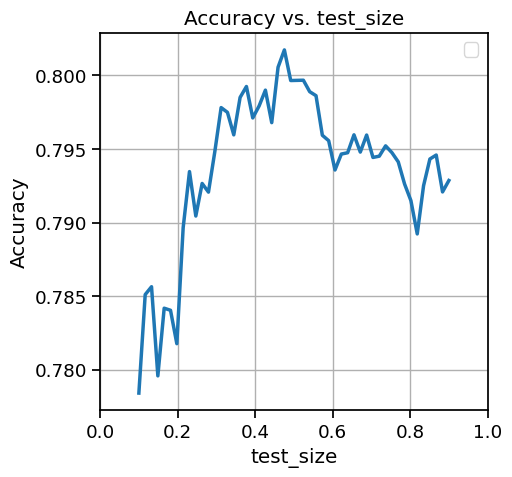

In [55]:
plt.figure(figsize=(5,5), dpi=100)
plt.plot(np.linspace(0.1,0.9,num=50), acc)
plt.xlim(0,1)
plt.xlabel('test_size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. test_size')
plt.grid(True)
plt.legend()
plt.show()

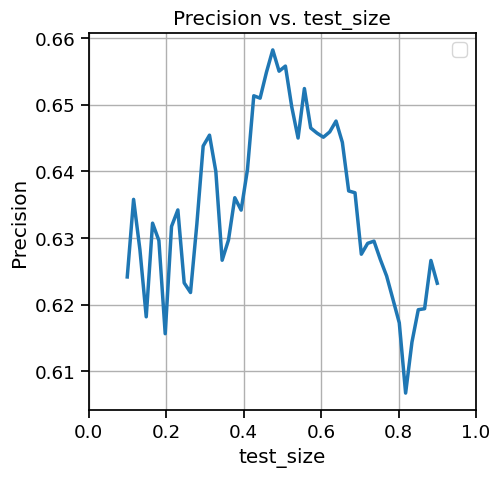

In [56]:
plt.figure(figsize=(5,5), dpi=100)
plt.plot(np.linspace(0.1,0.9,num=50), prec)
plt.xlim(0,1)
plt.xlabel('test_size')
plt.ylabel('Precision')
plt.title('Precision vs. test_size')
plt.grid(True)
plt.legend()
plt.show()

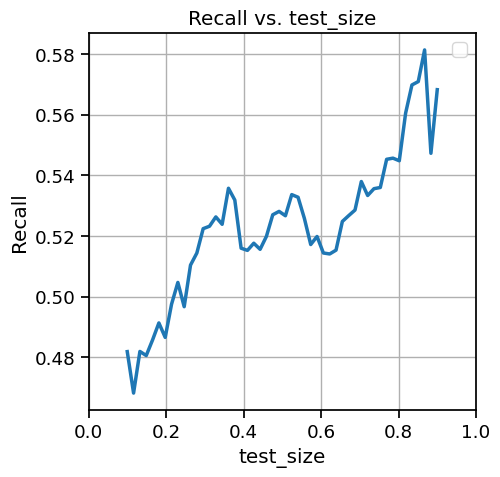

In [57]:
plt.figure(figsize=(5,5), dpi=100)
plt.plot(np.linspace(0.1,0.9,num=50), rec)
plt.xlim(0,1)
plt.xlabel('test_size')
plt.ylabel('Recall')
plt.title('Recall vs. test_size')
plt.grid(True)
plt.legend()
plt.show()

- For all four performances 0.2 < test_size < 0.4 seems the best choise.
- Once above 0.4 less and less data will be used to train the model and overfitting is likely to occur.
- I decided to go for 0.35.

### <a id='6.7'>6.7. Feature selection impact on the performance of all 4 models</a>

In [58]:
print(X.shape)
print(X.columns)

(7032, 19)
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_bin_round',
       'MonthlyCharges_bin_round', 'TotalCharges_bin_round'],
      dtype='object')


In [59]:
df_joined = X
df_joined['Churn'] = y
df_copy = df_joined

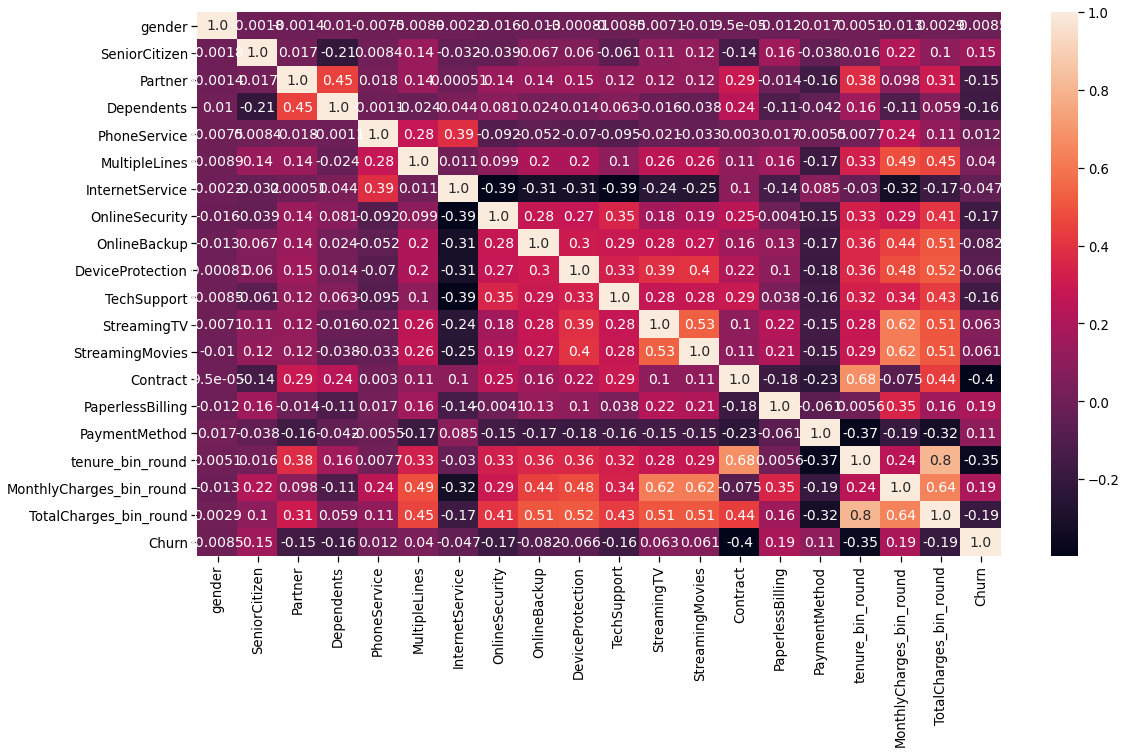

In [60]:
plt.figure(figsize=(18,10))
sns.heatmap(df_joined.corr(),annot=True, fmt=".2")

In [61]:
correlations = pd.DataFrame(df_joined.corr()['Churn'])
correlations = correlations.drop('Churn',axis=0)
correlations.sort_values(by=['Churn'],ascending=False)

,Churn
PaperlessBilling,0.191454
MonthlyCharges_bin_round,0.191297
SeniorCitizen,0.150541
PaymentMethod,0.107852
StreamingTV,0.063254
StreamingMovies,0.060860
MultipleLines,0.040033
PhoneService,0.011691
gender,-0.008545
InternetService,-0.047097


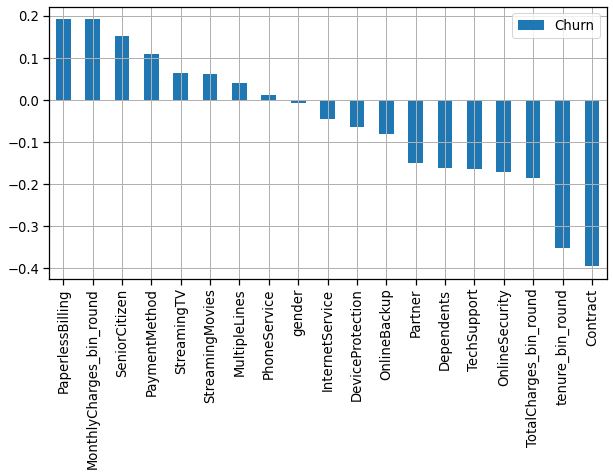

In [62]:
correlations.sort_values(by=['Churn'],ascending=False).plot(kind='bar',figsize=(10,5))
plt.grid()
plt.show()

Impact of removing features with abs(cor)<0.1

In [63]:
features_to_drop = correlations[abs(correlations['Churn'])<0].reset_index()['index'].to_list()
print(features_to_drop)

[]


In [64]:
df_joined = df_copy
df_joined = df_joined.drop(features_to_drop,axis=1)

In [65]:
X_features_reduced = df_joined.drop('Churn',axis=1)

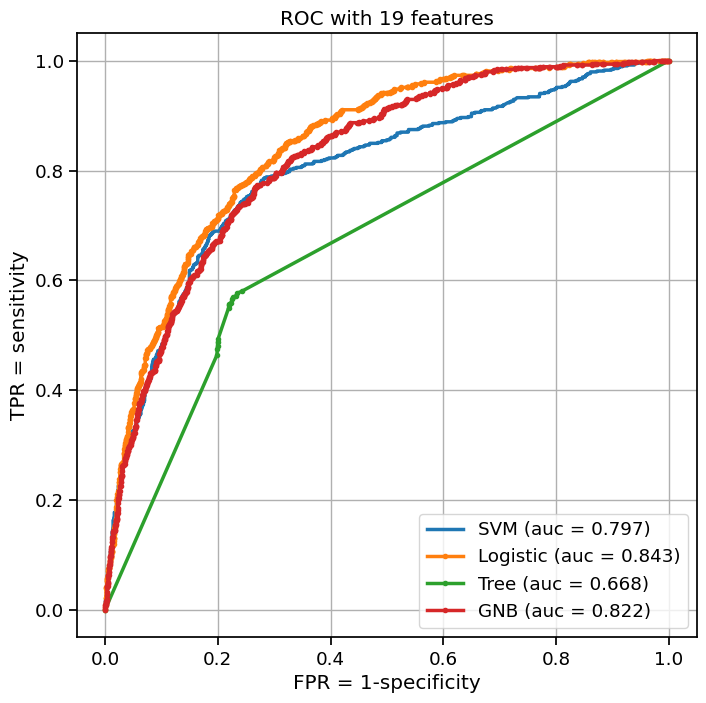

------------------------------
log_predictions_features_reduces
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1824
           1       0.64      0.53      0.58       638

    accuracy                           0.80      2462
   macro avg       0.74      0.71      0.72      2462
weighted avg       0.79      0.80      0.79      2462

------------------------------
SVM_predictions_features_reduces
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1824
           1       0.66      0.39      0.49       638

    accuracy                           0.79      2462
   macro avg       0.74      0.66      0.68      2462
weighted avg       0.77      0.79      0.77      2462

------------------------------
tree_predictions_features_reduces
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1824
           1       0.46      0.49      0.48 

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_features_reduced, y, test_size=0.35, random_state=42)

logmodel_features_reduces = LogisticRegression()
logmodel_features_reduces.fit(X_train,y_train)
log_predictions_features_reduces = logmodel_features_reduces.predict(X_test)

svc_model_features_reduces = SVC(kernel='rbf',random_state=4,probability=True)
svc_model_features_reduces.fit(X_train, y_train)
SVM_predictions_features_reduces = svc_model_features_reduces.predict(X_test)

tree_clf_features_reduces = tree.DecisionTreeClassifier(criterion='entropy')
tree_clf_features_reduces = tree_clf.fit(X_train, y_train)
tree_predictions_features_reduces = tree_clf_features_reduces.predict(X_test)

gnb_features_reduces = GaussianNB()
gnb_predictions_features_reduces = gnb_features_reduces.fit(X_train, y_train).predict(X_test)

# store the predicted probabilities for class 1
y_logistic_pred_prob_features_reduces = np.array(logmodel_features_reduces.predict_proba(X_test)[:,1]).reshape(-1,1)
y_svm_pred_prob_features_reduces = np.array(svc_model_features_reduces.predict_proba(X_test)[:,1]).reshape(-1,1)
y_tree_prob_features_reduces = np.array(tree_clf_features_reduces.predict_proba(X_test)[:,1]).reshape(-1,1)
y_gnb_prob_features_reduces = np.array(gnb_features_reduces.predict_proba(X_test)[:,1]).reshape(-1,1)

#logistic tpr and fpr
logistic_fpr, logistic_tpr, threshold_log = roc_curve(y_test, y_logistic_pred_prob_features_reduces)
auc_logistic = auc(logistic_fpr, logistic_tpr)

#SVM tpr and fpr
svm_fpr, svm_tpr, threshold_svm = roc_curve(y_test, y_svm_pred_prob_features_reduces)
auc_svm = auc(svm_fpr, svm_tpr)

#Tree tpr and fpr
tree_fpr, tree_tpr, threshold_tree = roc_curve(y_test, y_tree_prob_features_reduces,drop_intermediate=False)
auc_tree = auc(tree_fpr, tree_tpr)

#GNB tpr and fpr
gnb_fpr, gnb_tpr, threshold_gnb = roc_curve(y_test, y_gnb_prob_features_reduces)
auc_gnb = auc(gnb_fpr, gnb_tpr)


#plot
plt.figure(figsize=(8,8), dpi=100)
plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (auc = %0.3f)' % auc_svm)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)
plt.plot(tree_fpr, tree_tpr, marker='.', label='Tree (auc = %0.3f)' % auc_tree)
plt.plot(gnb_fpr, gnb_tpr, marker='.', label='GNB (auc = %0.3f)' % auc_gnb)

plt.xlabel('FPR = 1-specificity')
plt.ylabel('TPR = sensitivity')
plt.title('ROC with {} features'.format(len(X_test.columns)))
plt.grid(True)
plt.legend()
plt.show()

print('-'*30)
print('log_predictions_features_reduces')
print(classification_report(y_test,log_predictions_features_reduces))
print('-'*30)
print('SVM_predictions_features_reduces')
print(classification_report(y_test,SVM_predictions_features_reduces))
print('-'*30)
print('tree_predictions_features_reduces')
print(classification_report(y_test,tree_predictions_features_reduces))
print('-'*30)
print('gnb_predictions_features_reduces')
print(classification_report(y_test,gnb_predictions_features_reduces))

- Removing features with abs(correlation) <0.05 did not improve the performance for any of the 4 models.
- I also experimenten with a for loop to try all the different correlation tresholds, ranging from all the features to only 1 feature to train the model. The best performance was using all the features.

## <a id='7'>7. Create function to predict churn probability via API</a>

In [67]:
X_test

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure_bin_round,MonthlyCharges_bin_round,TotalCharges_bin_round
2476,1,1,1,0,1,1,2,0,0,0,0,0,0,2,0,0,15,1,1
6773,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,4,1,0
6116,1,0,1,0,1,1,1,0,0,1,0,1,1,0,1,1,3,9,1
3047,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,3,9,4,2
4092,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,5,3,1
528,0,1,0,0,1,1,1,0,1,1,1,1,0,2,1,0,14,8,5
3133,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,0,3,0
192,0,0,1,1,1,0,2,0,0,0,0,0,0,2,0,0,17,0,1


In [68]:
X_test = X_test.reset_index()[X_test.columns]
y_test = pd.DataFrame(y_test)
y_test = y_test.reset_index()[y_test.columns]
X_test.shape

(2462, 19)

In [69]:
print(np.array(X_test.iloc[400].to_list()).reshape(1,-1))
print(y_test.iloc[400].to_list())

[[0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 2 8 5 2]]
[1]


In [70]:
random_person = np.array(X_test.iloc[np.random.randint(0, 703 + 1)].to_list()).reshape(1,-1)

print(logmodel.predict(random_person))
print(logmodel.predict_proba(random_person))

[0]
[[0.99516318 0.00483682]]


In [71]:
def will_i_churn_or_not(gender,
                     SeniorCitizen,
                     Partner,
                     Dependents,
                     PhoneService,
                     MultipleLines,
                     InternetService,
                     OnlineSecurity,
                     OnlineBackup,
                     DeviceProtection,
                     TechSupport,
                     StreamingTV,
                     StreamingMovies,
                     Contract,
                     PaperlessBilling,
                     PaymentMethod,
                     tenure_bin_round,
                     MonthlyCharges_bin_round,
                     TotalCharges_bin_round):
    
    my_df = pd.DataFrame(data=[gender,
                     SeniorCitizen,
                     Partner,
                     Dependents,
                     PhoneService,
                     MultipleLines,
                     InternetService,
                     OnlineSecurity,
                     OnlineBackup,
                     DeviceProtection,
                     TechSupport,
                     StreamingTV,
                     StreamingMovies,
                     Contract,
                     PaperlessBilling,
                     PaymentMethod,
                     tenure_bin_round,
                     MonthlyCharges_bin_round,
                     TotalCharges_bin_round]).transpose()
    
    the_probability = logmodel.predict_proba(my_df)
    
    the_prediction = logmodel.predict(my_df)
    
    if the_prediction == 0:
        print('The probability you will not churn is {:.3f}%'.format(the_probability[0][0]))
    else:
        print('The probability you will churn is {:.3f}%'.format(the_probability[0][1]))

In [72]:
random_person = np.array(X_test.iloc[np.random.randint(0, 703 + 1)].to_list()).reshape(1,-1)

In [73]:
tupled_person = tuple(random_person[0])

In [74]:
will_i_churn_or_not(*tupled_person)

The probability you will not churn is 0.999%


## <a id='8'> 8. Ranking top 20 customers most likely to churn</a>

In [75]:
churn_probability = pd.DataFrame(logmodel.predict_proba(X_test)[:,1], columns=['Churn_probability']) 
#for all the predictions (rows), give me the probabilities of churning (1)

In [76]:
churn_probability.sort_values(by='Churn_probability',ascending=False).head(20)

,Churn_probability
60,0.897756
2203,0.892056
1038,0.892056
170,0.892056
833,0.886699
1433,0.883522
1983,0.876650
903,0.876650
168,0.876650
1538,0.861751
